In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from datetime import datetime
from datetime import timedelta

In [63]:
df = pd.read_csv('../92-Site_DKA-M6_B-Phase.csv')

In [64]:
print(df.describe())

       Active_Energy_Delivered_Received  Current_Phase_Average  Active_Power  \
count                      1.573221e+06           1.573214e+06  1.573214e+06   
mean                       7.172700e+04           4.685938e+00  1.084910e+00   
std                        4.171347e+04           6.099162e+00  1.531835e+00   
min                        0.000000e+00           0.000000e+00 -4.000000e-02   
25%                        3.568800e+04           3.000000e-01  0.000000e+00   
50%                        7.234600e+04           3.000000e-01  0.000000e+00   
75%                        1.077950e+05           9.446667e+00  2.295450e+00   
max                        1.433680e+05           2.366600e+01  5.824800e+00   

       Performance_Ratio     Wind_Speed  Weather_Temperature_Celsius  \
count      868887.000000  841771.000000                 1.567197e+06   
mean          222.533198       2.508527                 2.112727e+01   
std          2884.587762       4.362972                 9.88285

In [65]:
print(df.head())

             timestamp  Active_Energy_Delivered_Received  \
0  2008-09-12 05:55:00                               0.0   
1  2008-09-12 06:00:00                               0.0   
2  2008-09-12 06:05:00                               0.0   
3  2008-09-12 06:10:00                               0.0   
4  2008-09-12 06:15:00                               0.0   

   Current_Phase_Average  Active_Power  Performance_Ratio  Wind_Speed  \
0                    0.0           0.0                NaN         NaN   
1                    0.0           0.0                NaN         NaN   
2                    0.0           0.0                NaN         NaN   
3                    0.0           0.0                NaN         NaN   
4                    0.0           0.0                NaN         NaN   

   Weather_Temperature_Celsius  Weather_Relative_Humidity  \
0                    25.734350                  18.551216   
1                    25.402353                  19.242727   
2                

In [66]:
print(df.isnull().sum())

timestamp                                0
Active_Energy_Delivered_Received      1238
Current_Phase_Average                 1245
Active_Power                          1245
Performance_Ratio                   705572
Wind_Speed                          732688
Weather_Temperature_Celsius           7262
Weather_Relative_Humidity             7262
Global_Horizontal_Radiation           7263
Diffuse_Horizontal_Radiation          7263
Wind_Direction                        9421
Weather_Daily_Rainfall                7238
Radiation_Global_Tilted             611886
Radiation_Diffuse_Tilted            569759
dtype: int64


In [67]:
print(df.columns)

Index(['timestamp', 'Active_Energy_Delivered_Received',
       'Current_Phase_Average', 'Active_Power', 'Performance_Ratio',
       'Wind_Speed', 'Weather_Temperature_Celsius',
       'Weather_Relative_Humidity', 'Global_Horizontal_Radiation',
       'Diffuse_Horizontal_Radiation', 'Wind_Direction',
       'Weather_Daily_Rainfall', 'Radiation_Global_Tilted',
       'Radiation_Diffuse_Tilted'],
      dtype='object')


In [68]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

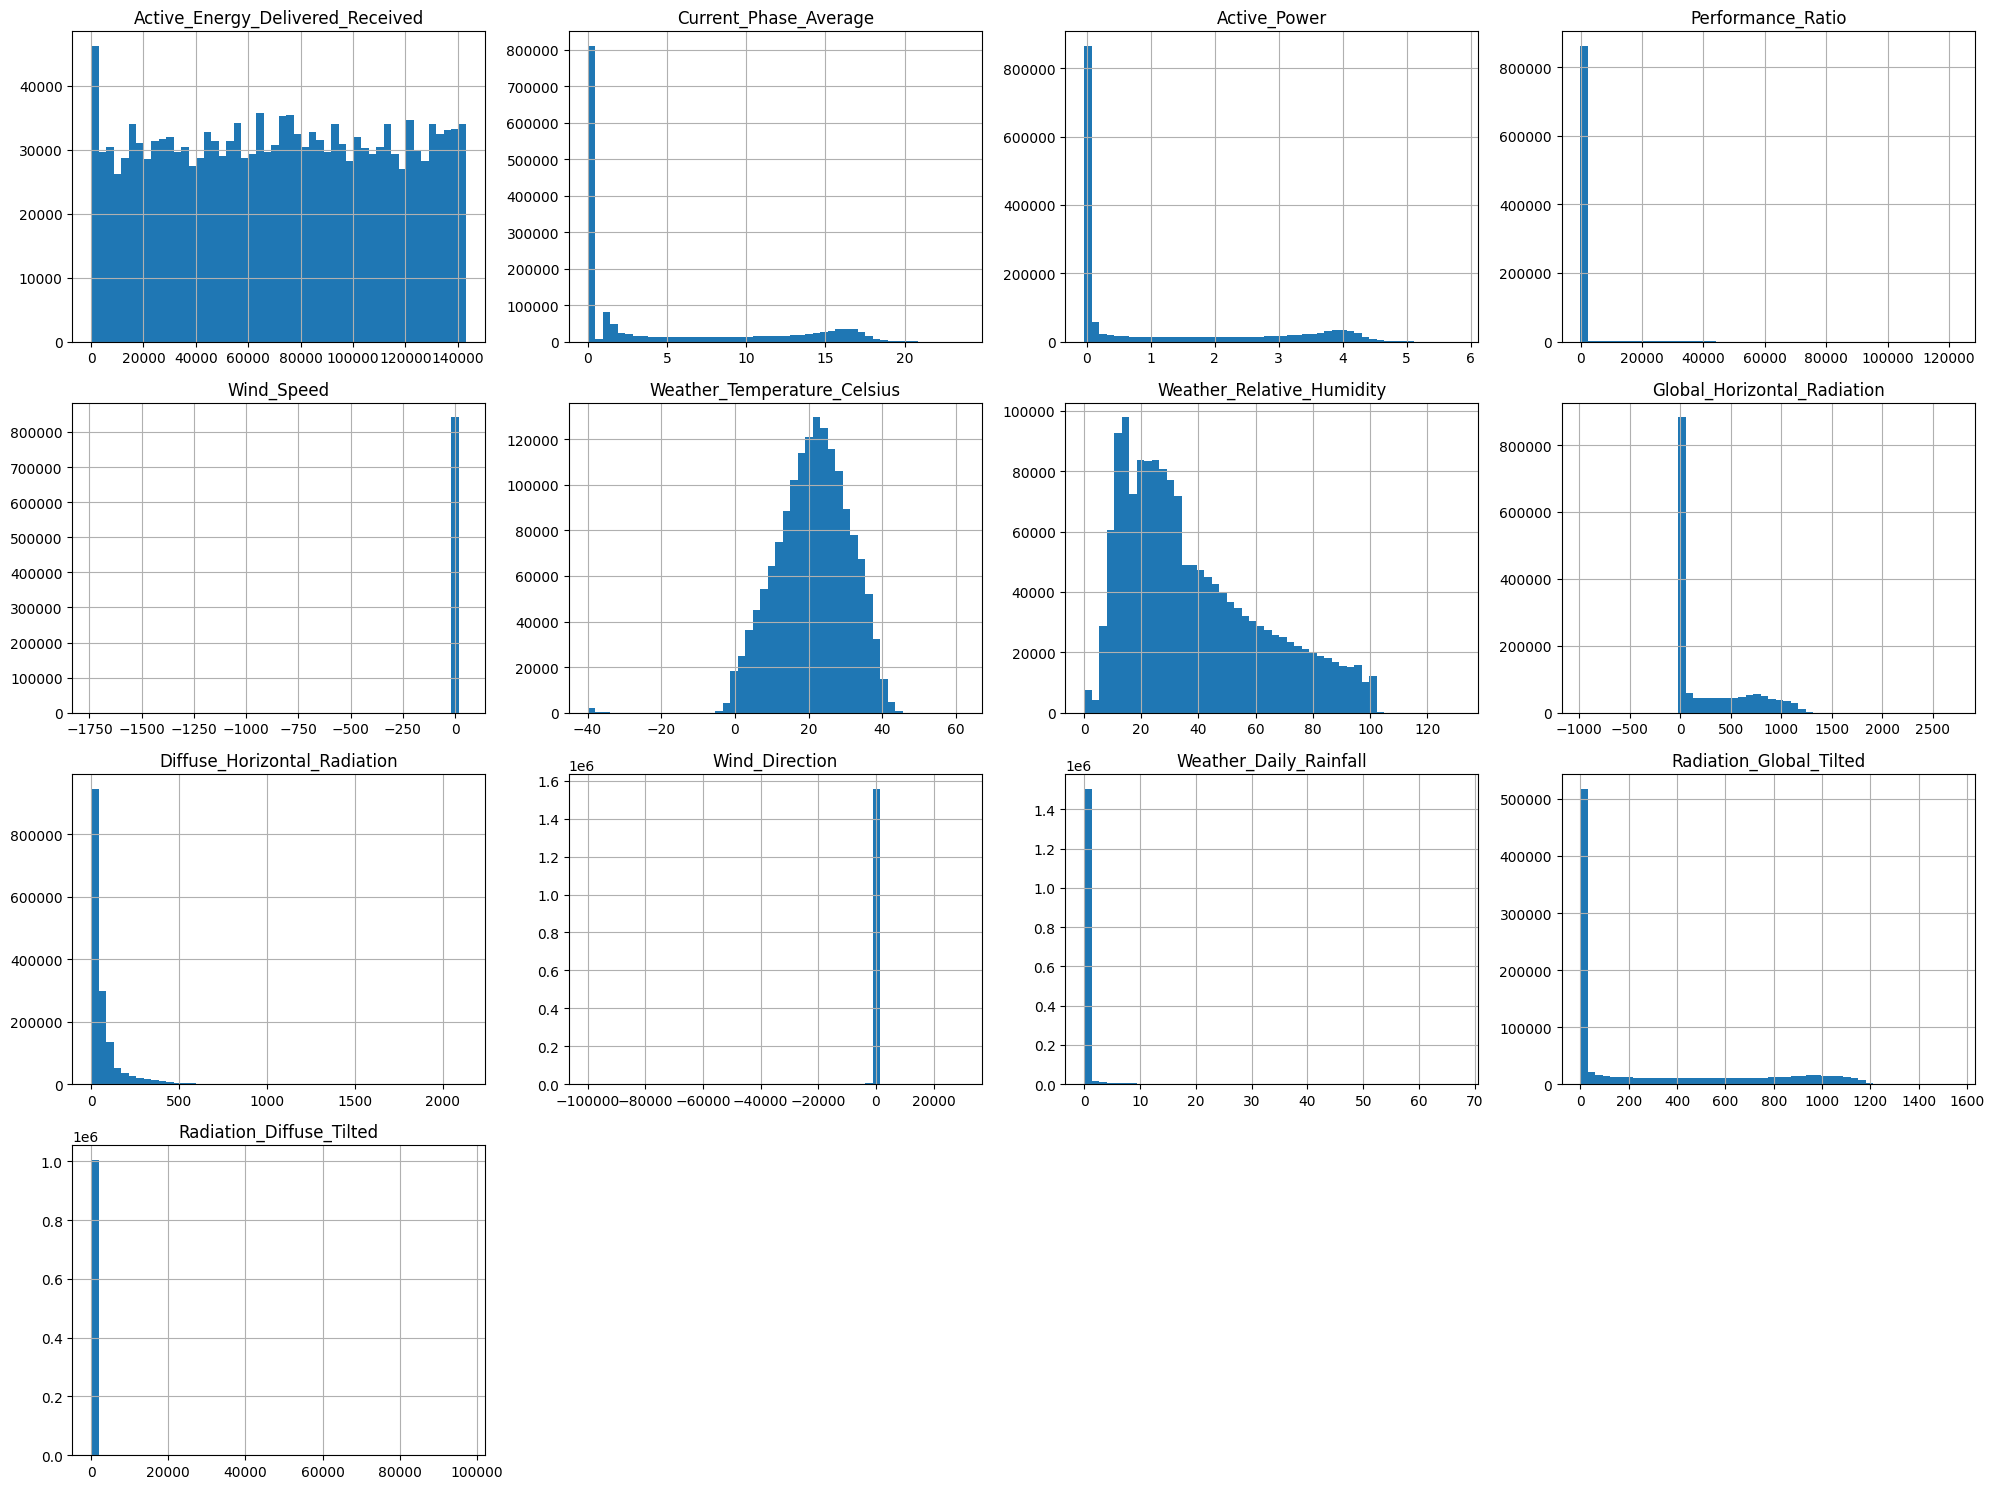

In [69]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 4, i)
    df[feature].hist(bins=50)
    plt.title(feature)

plt.tight_layout()
plt.show()

In [70]:
# Display basic statistics for 'Active_Power'
active_power_stats = df['Active_Power'].describe()
print("Statistics for Active_Power:")
print(active_power_stats)

Statistics for Active_Power:
count    1.573214e+06
mean     1.084910e+00
std      1.531835e+00
min     -4.000000e-02
25%      0.000000e+00
50%      0.000000e+00
75%      2.295450e+00
max      5.824800e+00
Name: Active_Power, dtype: float64


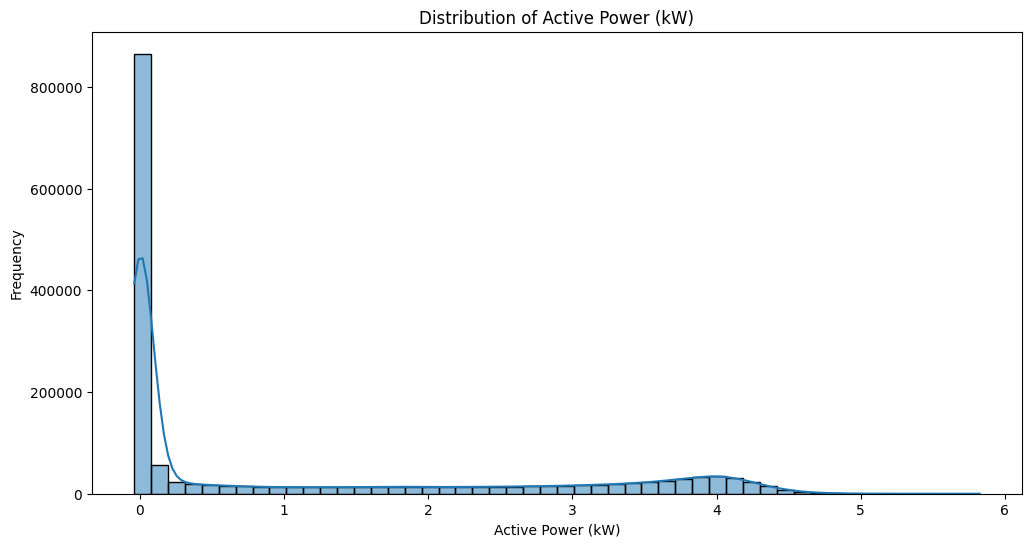

In [71]:
# Plot the distribution of 'Active_Power'
plt.figure(figsize=(12, 6))
sns.histplot(df['Active_Power'], bins=50, kde=True)
plt.title('Distribution of Active Power (kW)')
plt.xlabel('Active Power (kW)')
plt.ylabel('Frequency')
plt.show()

In [72]:
# def clean_data(df):
#     column_names = df.columns
#     clean_names = [name.replace(' ', '_') for name in column_names] # remove any existing prefixes in column names
#     df.columns = clean_names

#     df.index = pd.to_datetime(df['timestamp']) # convert the timestamp column to a datetime index
#     df.drop('timestamp', axis=1, inplace=True)

#     df.fillna(0, inplace=True) # fill in any missing values with 0s

#     new_index = pd.date_range(df.index.min(), df.index.max(), freq='5min') # create a consistent time series index and impute missing timestamps
#     df_imputed = pd.DataFrame(index=new_index)
#     df_imputed = df.asof(pd.DatetimeIndex(new_index))
#     df_imputed.fillna(0, inplace=True)
    
#     return df_imputed

In [73]:
def clean_data(df):
    """
    Removes rows with missing values in the 'Active_Power' column from the input DataFrame.
    
    Parameters:
        df (pandas.DataFrame): The input DataFrame.
        
    Returns:
        pandas.DataFrame: The cleaned DataFrame.
    """
    # Remove rows where 'Active_Power' is NaN
    cleaned_df = df.dropna(subset=['Active_Power'])
    
    return cleaned_df

In [74]:
cleaned_df = clean_data(df)
print(cleaned_df.head())

             timestamp  Active_Energy_Delivered_Received  \
0  2008-09-12 05:55:00                               0.0   
1  2008-09-12 06:00:00                               0.0   
2  2008-09-12 06:05:00                               0.0   
3  2008-09-12 06:10:00                               0.0   
4  2008-09-12 06:15:00                               0.0   

   Current_Phase_Average  Active_Power  Performance_Ratio  Wind_Speed  \
0                    0.0           0.0                NaN         NaN   
1                    0.0           0.0                NaN         NaN   
2                    0.0           0.0                NaN         NaN   
3                    0.0           0.0                NaN         NaN   
4                    0.0           0.0                NaN         NaN   

   Weather_Temperature_Celsius  Weather_Relative_Humidity  \
0                    25.734350                  18.551216   
1                    25.402353                  19.242727   
2                

### Time series methods

#### Deviation from the mean

Here we just classify any point that falls out of the range (3 standard deviations) as an anomaly.  

Another approach is get the mean average of each hour of the day (grouping the data by the hour and getting the mean), and then getting a sense of what the typical active power should be for each hour, and calculating confidence intervals (also based on the standard deviation for each hour) for the mean active power each hour.  Then we could classify anything outside of those confidence intervals of 99% as an anomaly.

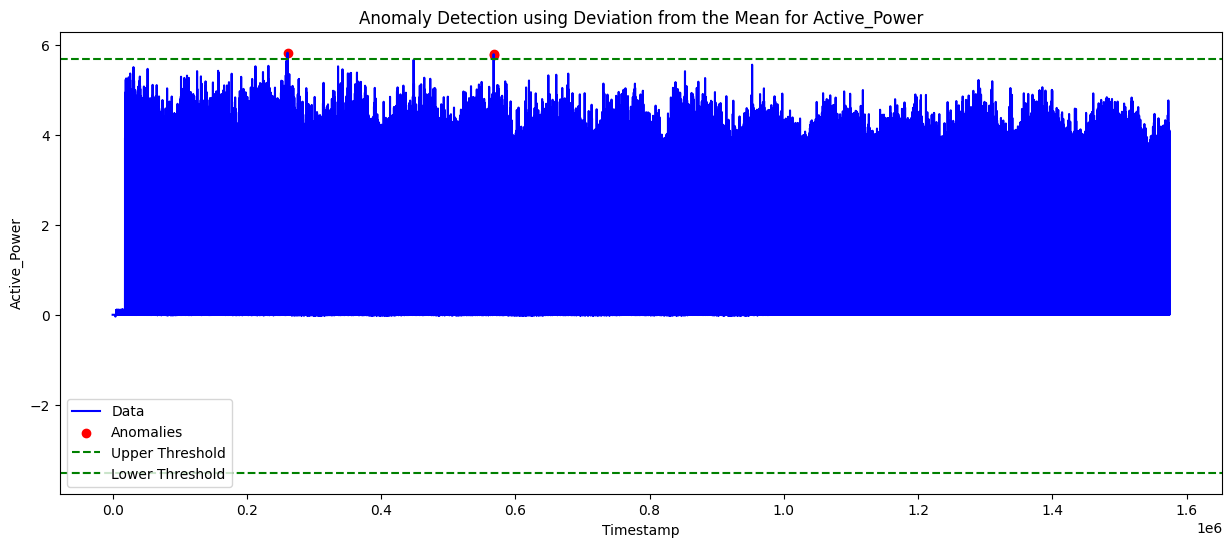

In [75]:
feature = 'Active_Power' # detect anomalies for the Active Power feature
data = cleaned_df[feature]

mean_value = np.mean(data)
std_value = np.std(data)

threshold = 3 * std_value # use 3 standard deviations as the threshold

anomalies = data[(data < mean_value - threshold) | (data > mean_value + threshold)]

plt.figure(figsize=(15, 6))
plt.plot(data.index, data, label='Data', color='blue')
plt.scatter(anomalies.index, anomalies, color='red', label='Anomalies')
plt.axhline(y=mean_value + threshold, color='g', linestyle='--', label='Upper Threshold')
plt.axhline(y=mean_value - threshold, color='g', linestyle='--', label='Lower Threshold')
plt.title(f"Anomaly Detection using Deviation from the Mean for {feature}")
plt.xlabel("Timestamp")
plt.ylabel(feature)
plt.legend()
plt.show()


### ML approaches

#### k-Nearest Neighbors (k-NN)

k-NN algorithm classifies a data point based upon how its neighbors are also classified.  To apply it to anomaly detection, we can classify a point as an anomaly if its distance to its kth nearest neighbor is above a certain threshold.

In [76]:
# feature_data = cleaned_df[['Active_Power']].values # convert the feature column to a NumPy array for k-NN
# feature_data = feature_data.reshape(-1, 1)

# knn_model = NearestNeighbors(n_neighbors=5) # init model
# knn_model.fit(feature_data)

# distances, indices = knn_model.kneighbors(feature_data) # find the k-neighbors of each point

# kth_distances = distances[:, 4] # calculate the distance to the kth nearest neighbor (k=5)

# distance_threshold = 1.5 * np.mean(kth_distances) # use 1.5 times the mean as the threshold for anomalies

# anomaly_indices = np.where(kth_distances > distance_threshold)[0] # Identify anomalies (points where the distance to the kth neighbor is greater than the threshold)
# anomalies_knn = cleaned_df.iloc[anomaly_indices]

# print(anomalies_knn.head()) 

k-NN is O(N) time and memory complexity for querying all the points, so this could take quite a long time

Might need to use an optimized algorithm like kd-tree or ball tree to reduce the query time to O(log N) for each point

Sampling doesn't seem appropriate here, since it would miss anomalies, but perhaps windowing and getting a sense of what it's like to apply k-NN to each window would be useful here

In [77]:
# # Plotting the data and anomalies
# plt.figure(figsize=(15, 6))
# plt.plot(cleaned_df.index, cleaned_df['Active_Power'], label='Data', color='blue')
# plt.scatter(anomalies_knn.index, anomalies_knn['Active_Power'], color='red', label='Anomalies')
# plt.title('k-NN Anomaly Detection for Active_Power')
# plt.xlabel('Timestamp')
# plt.ylabel('Active_Power')
# plt.legend()
# plt.show()

# # Display anomalies
# print(anomalies_knn.head())

#### Catboost

In [84]:
# not much feature engineering at this point, try out all features
cat_boost_features = cleaned_df.columns.drop(['timestamp', 'Active_Power'])
X = cleaned_df[cat_boost_features].fillna(0)  # Fill any remaining NaNs with 0


In [85]:
# Step 2: Labeling
# Marking data points below the 1st percentile or above the 99th percentile as anomalies (label=1, else label=0)
thresholds = cleaned_df['Active_Power'].quantile([0.01, 0.99]).values
y = ((cleaned_df['Active_Power'] <= thresholds[0]) | (cleaned_df['Active_Power'] >= thresholds[1])).astype(int)

In [86]:
# Step 3: Model Training
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [90]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    verbose=200,
    eval_metric='AUC',
    random_seed=42
)

In [91]:
# Train the model
train_data = Pool(data=X_train, label=y_train)
test_data = Pool(data=X_test, label=y_test)
model.fit(train_data, eval_set=test_data)


0:	test: 0.9987073	best: 0.9987073 (0)	total: 174ms	remaining: 1m 26s
200:	test: 0.9998937	best: 0.9998937 (200)	total: 18.2s	remaining: 27s
400:	test: 0.9999157	best: 0.9999157 (398)	total: 35.5s	remaining: 8.76s
499:	test: 0.9999178	best: 0.9999178 (456)	total: 46.5s	remaining: 0us

bestTest = 0.9999177983
bestIteration = 456

Shrink model to first 457 iterations.


Uh definitely overfitting

In [92]:
# Step 4: Evaluation
# Evaluate the model on the test set
model_eval = model.eval_metrics(test_data, metrics=['Logloss', 'AUC'])

# Print the evaluation metrics
print("AUC:", model_eval['AUC'][-1])
print("Logloss:", model_eval['Logloss'][-1])

AUC: 0.9999177982930695
Logloss: 0.01004943982670836


Very high AUC and very low logloss (performance of model where input is probability 0-1) suggest good performance, but also signs of overfitting.  

However, the model seems to perform the same between training and test set.

In [94]:
# Feature Importance
feature_importances = model.get_feature_importance(train_data)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print(f"{name}: {score}")


Current_Phase_Average: 20.609514669175198
Performance_Ratio: 19.621315392855955
Global_Horizontal_Radiation: 18.96650012153977
Diffuse_Horizontal_Radiation: 14.27521406626431
Active_Energy_Delivered_Received: 13.010142984900193
Radiation_Diffuse_Tilted: 4.601516073206264
Weather_Relative_Humidity: 3.114895121251497
Weather_Temperature_Celsius: 2.610503327488029
Wind_Speed: 1.4560495603909815
Radiation_Global_Tilted: 0.8710465164452725
Wind_Direction: 0.7961459285946711
Weather_Daily_Rainfall: 0.06715623788787517


Current Phase Average, Performance Ratio, Global_Horizontal_Radiation (and maybe Diffuse_Horizontal_Radiation, and Active_Energy_Delivered_Received) seem pretty predictive.  

In [95]:
# Step 1: Feature Pruning
# Include only the top features based on feature importance
top_features = ['Current_Phase_Average', 'Performance_Ratio', 'Global_Horizontal_Radiation', 
                'Diffuse_Horizontal_Radiation', 'Active_Energy_Delivered_Received']
X = cleaned_df[top_features].fillna(0)  # Fill any remaining NaNs with 0

In [104]:
def clean_data(df):
    cleaned_df = df.dropna(subset=['Active_Power'])
    return cleaned_df

def create_labels(df, column='Active_Power'):
    thresholds = df[column].quantile([0.01, 0.99]).values
    labels = ((df[column] <= thresholds[0]) | (df[column] >= thresholds[1])).astype(int)
    return labels

def train_evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    model = CatBoostClassifier(
        iterations=300, # reduced from 500 to 300 to try to reduce overfitting
        learning_rate=0.1,
        depth=4, # reduced from 6 to 4
        verbose=200,
        eval_metric='AUC',
        random_seed=42,
        l2_leaf_reg=3,
        random_strength=1,
    )
    
    train_data = Pool(data=X_train, label=y_train)
    test_data = Pool(data=X_test, label=y_test)
    model.fit(train_data, eval_set=test_data)
    
    model_eval = model.eval_metrics(test_data, metrics=['Logloss', 'AUC'])
    return model, model_eval


In [105]:
# Create labels
y = create_labels(cleaned_df)

# Feature Pruning: Use only top features
top_features = ['Current_Phase_Average', 'Performance_Ratio', 'Global_Horizontal_Radiation', 
                'Diffuse_Horizontal_Radiation', 'Active_Energy_Delivered_Received']
X_top_features = cleaned_df[top_features].fillna(0)

# Train and evaluate model with top features
model, model_eval = train_evaluate_model(X_top_features, y)

# Output evaluation metrics
print("AUC:", model_eval['AUC'][-1])
print("Logloss:", model_eval['Logloss'][-1])

0:	test: 0.9960316	best: 0.9960316 (0)	total: 77ms	remaining: 23s
200:	test: 0.9997536	best: 0.9997536 (200)	total: 13.7s	remaining: 6.77s
299:	test: 0.9997707	best: 0.9997707 (225)	total: 19.8s	remaining: 0us

bestTest = 0.9997706657
bestIteration = 225

Shrink model to first 226 iterations.
AUC: 0.9997706657231357
Logloss: 0.012661460701962248


Model still does really well; made model less complex, but retained predictive power.  But should really do something about the overfitting

Use l2_leaf_reg for L2 regularization, and random_strength to add randomness.  Doesn't seem like they helped.

After making the model less complex by reducing iterations and tree depth, it reached the best iteration is now 225, down from 499 previously. This means the model reached its best performance faster, indicating a less complex model.

In [111]:
def plot_validation_curve(X, y, param_name, param_range):
    train_scores = []
    test_scores = []
    
    for param_value in param_range:
        model, model_eval = train_evaluate_model(X, y, **{param_name: param_value})
        train_scores.append(model_eval['AUC'][-1])
        test_scores.append(model.get_best_score()['validation']['AUC'])
        
    plt.figure()
    plt.title(f"Validation Curve with CatBoost ({param_name})")
    plt.xlabel(param_name)
    plt.ylabel("AUC")
    plt.plot(param_range, train_scores, label="Training score", color="r")
    plt.plot(param_range, test_scores, label="Cross-validation score", color="g")
    plt.legend(loc="best")
    plt.show()

# Call the function
plot_validation_curve(X_top_features, y, 'depth', np.arange(2, 10, 2))

TypeError: train_evaluate_model() got an unexpected keyword argument 'depth'

In [ ]:
def plot_learning_curve(X, y, estimator, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# Prepare the estimator
best_model = CatBoostClassifier(iterations=300, learning_rate=0.1, depth=4, verbose=0, eval_metric='AUC', random_seed=42)
  
# Call the function
plot_learning_curve(X_top_features, y, best_model, "Learning Curve (CatBoost)")

In [106]:
# # Prepare the data (Only 'Active_Power' feature is used here)
# X = cleaned_df[['Active_Power']].values

# # Create labels (mostly ones, with a small fraction of zeros for the "dummy" class)
# y = np.ones(X.shape[0])
# y[:10] = 0  # Assign the first 10 instances to the "dummy" class

# # Initialize CatBoost classifier
# catboost_model = CatBoostClassifier(iterations=100, verbose=0, one_hot_max_size=3)

# # Train the model
# catboost_model.fit(X, y)

# # Predict the probabilities [dummy, normal] for each instance in the dataset
# pred_prob = catboost_model.predict_proba(X)

# # Extract the normal class probabilities
# normal_prob = pred_prob[:, 1]

# # Determine a probability threshold for anomalies (e.g., below 0.9 or 90%)
# prob_threshold = 0.9

# # Identify anomalies (instances where the normal probability is below the threshold)
# anomaly_indices = np.where(normal_prob < prob_threshold)[0]
# anomalies_catboost = cleaned_df.iloc[anomaly_indices]

In [107]:
# # Plotting the data and anomalies
# plt.figure(figsize=(15, 6))
# plt.plot(cleaned_df.index, cleaned_df['Active_Power'], label='Data', color='blue')
# plt.scatter(anomalies_catboost.index, anomalies_catboost['Active_Power'], color='red', label='Anomalies')
# plt.title('CatBoost Anomaly Detection for Active_Power')
# plt.xlabel('Timestamp')
# plt.ylabel('Active_Power')
# plt.legend()
# plt.show()

# # Display anomalies
# print(anomalies_catboost.head())


#### XGBoost

<!-- # Prepare the data (Only 'Active_Power' feature is used here)
X = cleaned_df[['Active_Power']].values

# Create labels (mostly ones, with a small fraction of zeros for the "dummy" class)
y = np.ones(X.shape[0])
y[:10] = 0  # Assign the first 10 instances to the "dummy" class

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Train the model
xgb_model.fit(X, y)

# Predict the probabilities [dummy, normal] for each instance in the dataset
pred_prob = xgb_model.predict_proba(X)

# Extract the normal class probabilities
normal_prob = pred_prob[:, 1]

# Determine a probability threshold for anomalies (e.g., below 0.9 or 90%)
prob_threshold = 0.9

# Identify anomalies (instances where the normal probability is below the threshold)
anomaly_indices = np.where(normal_prob < prob_threshold)[0]
anomalies_xgb = cleaned_df.iloc[anomaly_indices]

# Plotting the data and anomalies
plt.figure(figsize=(15, 6))
plt.plot(cleaned_df.index, cleaned_df['Active_Power'], label='Data', color='blue')
plt.scatter(anomalies_xgb.index, anomalies_xgb['Active_Power'], color='red', label='Anomalies')
plt.title('XGBoost Anomaly Detection for Active_Power')
plt.xlabel('Timestamp')
plt.ylabel('Active_Power')
plt.legend()
plt.show()

# Display anomalies
print(anomalies_xgb.head()) -->

Cross validate the model, tune the estimator's hyperparameters, produce validatino and learning curves

<!-- # Prepare the data (Only 'Active_Power' feature is used here)
X = cleaned_df[['Active_Power']].values

# Initialize PCA (with 1 principal component, as we're using only one feature)
pca = PCA(n_components=1)

# Fit the PCA model and transform the data
X_pca = pca.fit_transform(X)

# Reconstruct the original data from the principal components
X_reconstructed = pca.inverse_transform(X_pca)

# Calculate the reconstruction error (squared error between original and reconstructed data)
reconstruction_error = np.sum((X - X_reconstructed) ** 2, axis=1)

# Determine a threshold for anomalies (e.g., 99th percentile of the reconstruction error)
error_threshold = np.percentile(reconstruction_error, 99)

# Identify anomalies (instances where the reconstruction error is above the threshold)
anomaly_indices = np.where(reconstruction_error > error_threshold)[0]
anomalies_pca = cleaned_df.iloc[anomaly_indices]

# Plotting the data and anomalies
plt.figure(figsize=(15, 6))
plt.plot(cleaned_df.index, cleaned_df['Active_Power'], label='Data', color='blue')
plt.scatter(anomalies_pca.index, anomalies_pca['Active_Power'], color='red', label='Anomalies')
plt.title('PCA-Based Anomaly Detection for Active_Power')
plt.xlabel('Timestamp')
plt.ylabel('Active_Power')
plt.legend()
plt.show()

# Display anomalies
print(anomalies_pca.head()) -->

In [108]:
# X = cleaned_df[['Active_Power']].values

# # Initialize Isolation Forest
# isolation_forest = IsolationForest(contamination=0.01)  # Setting contamination to handle 1% of outliers

# # Fit the model
# isolation_forest.fit(X)

# # Predict the anomaly scores
# anomaly_scores = isolation_forest.decision_function(X)

# # Determine a threshold for anomalies (e.g., 5th percentile of the anomaly scores)
# score_threshold = np.percentile(anomaly_scores, 5)

# # Identify anomalies (instances where the anomaly score is below the threshold)
# anomaly_indices = np.where(anomaly_scores < score_threshold)[0]
# anomalies_isolation_forest = cleaned_df.iloc[anomaly_indices]

# # Plotting the data and anomalies
# plt.figure(figsize=(15, 6))
# plt.plot(cleaned_df.index, cleaned_df['Active_Power'], label='Data', color='blue')
# plt.scatter(anomalies_isolation_forest.index, anomalies_isolation_forest['Active_Power'], color='red', label='Anomalies')
# plt.title('Isolation Forest Anomaly Detection for Active_Power')
# plt.xlabel('Timestamp')
# plt.ylabel('Active_Power')
# plt.legend()
# plt.show()

# # Display anomalies
# print(anomalies_isolation_forest.head())